# Dataset loading and visualization

In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hashlib

#Collect the data from online repository
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH =  "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

#Functions to get the data
def fetchHousingData(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
    
def loadHousingData(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


def splitTrainTest(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def testSetCheck(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1]<256*test_ratio

def splitTrainTestById(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: testSetCheck(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [2]:
#Get your data
fetchHousingData()
housing = loadHousingData()

#Look at the first few lines of your data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
#cumulitve information on your data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
#returns basic statistics on the dataFrame
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


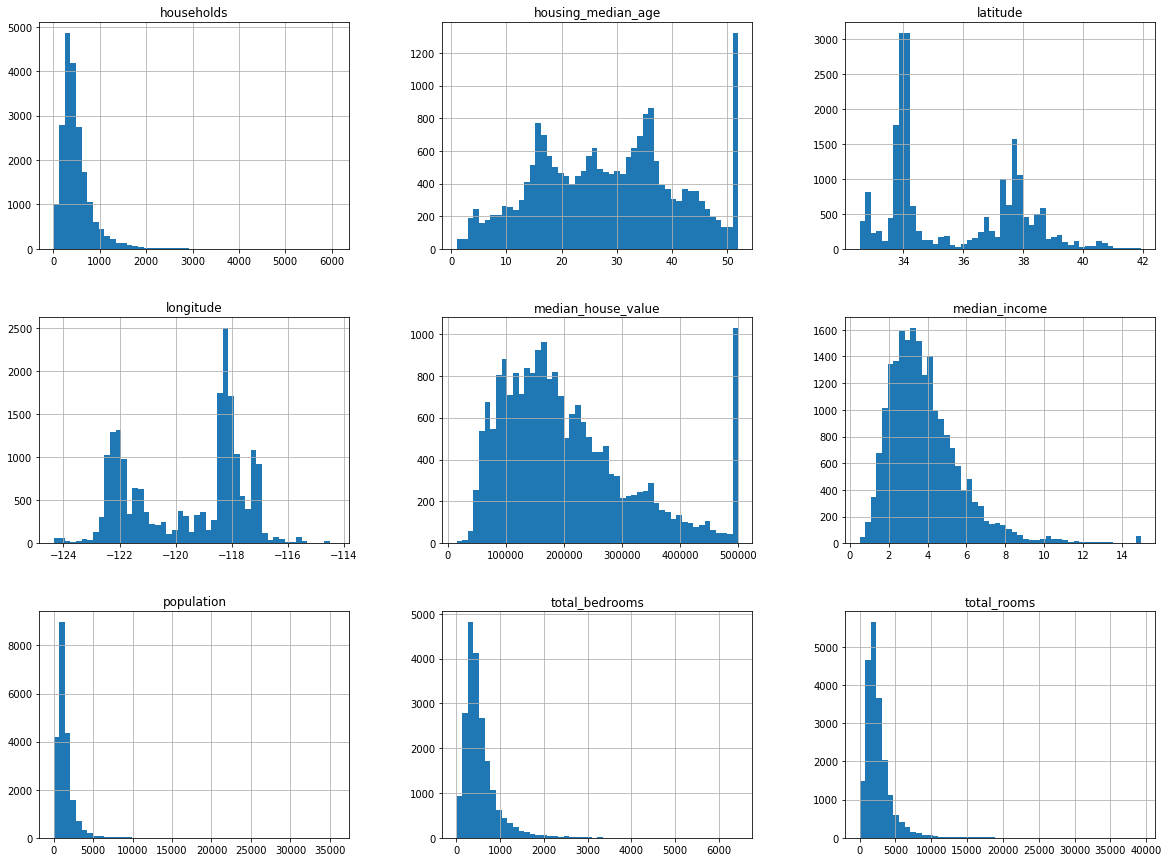

In [5]:
#Creates histograms on the nine float64 datatypes
housing.hist(bins=50, figsize=(20,15))
plt.show()

# Training and testing dataset creation

In [6]:
# #This will generate a new random Training/ Test sets: Not good for repeat runs
# trainset, testset = splitTrainTest(housing, 0.2)
# print(len(trainset), "train", len(testset), "test")

#Create an index column in the dataset with ID to ensure that each run, it pulls the correct set of data
housing_with_id = housing.reset_index() #adds an 'index' column by assigning row index as the ID
trainset, testset = splitTrainTestById(housing_with_id, 0.2, "index")
print(len(trainset), "train", len(testset), "test")

#one could also stratify your split based on a specific feature you are interested in exploring
from sklearn.model_selection import StratifiedShuffleSplit

#come up with the measure used to stratify
housing["income_cat"]=np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace= True)

#bias split based on the stratification
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
housing["income_cat"].value_counts() / len(housing) #Display the relative numbers in the stratified dataset

for set in (strat_train_set, strat_test_set): #Get rid of the created qualifying measure
    set.drop(["income_cat"], axis=1, inplace=True)

16362 train 4278 test


# Discovery and Visualize the Data to gain insight

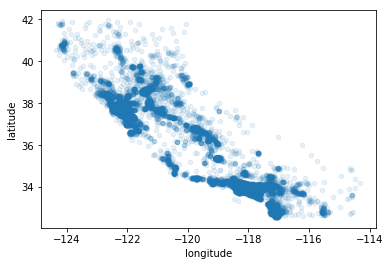

In [7]:
housing = strat_train_set.copy()
housing.plot(kind='scatter', x="longitude", y="latitude", alpha=0.1) #alpha will allow us to visualize the density of the scatter plot
plt.show()

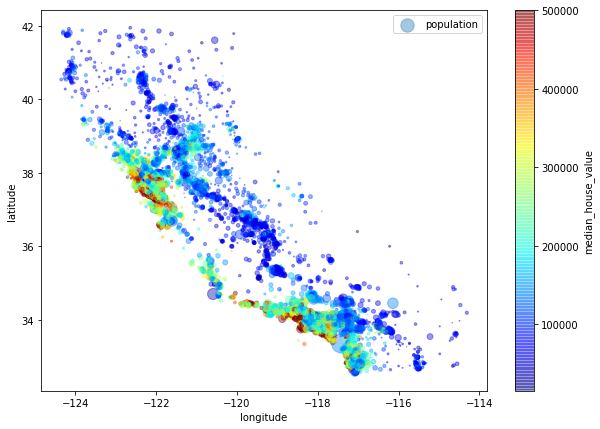

In [8]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
plt.show()

In [9]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


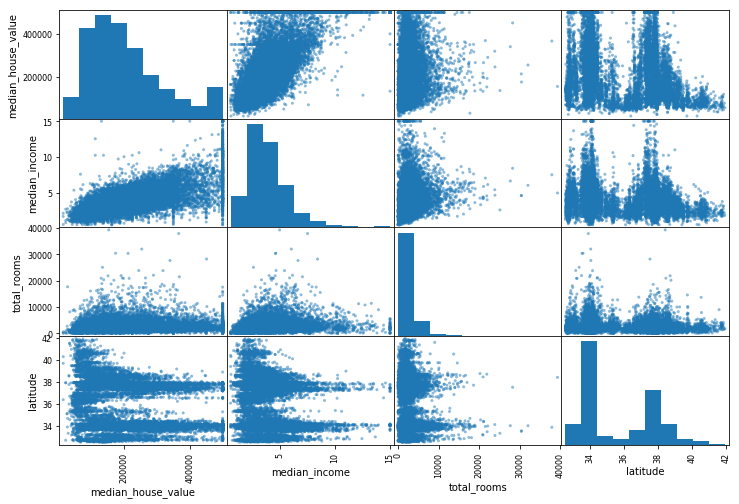

In [14]:
from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'latitude']
scatter_matrix(housing[attributes], figsize =(12,8))
plt.show()

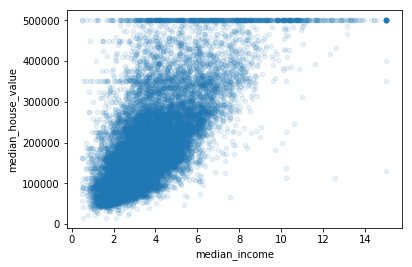

'Note the quirks in the data that may lead to unexpected machine learning.\nHorizontal lines at $500,000 based on price cap, other less noticeable $450,000, $350,000, $280,000\nYou may want to remove the corresponding diesctics to preven your algorithm from learning to reproduce\nthese data quirks'

In [11]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha= 0.1)
plt.show()
'''Note the quirks in the data that may lead to unexpected machine learning.
Horizontal lines at $500,000 based on price cap, other less noticeable $450,000, $350,000, $280,000
You may want to remove the corresponding diesctics to preven your algorithm from learning to reproduce
these data quirks'''

# Add more measures that make intuitive sense to look at

housing['rooms_per_household'] = housing["total_rooms"]/housing["households"] #rooms per household
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] #number of bedrooms to total number of rooms
housing["population_per_household"] = housing["population"]/housing["households"] 

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

# Prepare data for Machine Learning Algorithms

## Machine learning doesnt work well with missing features:

### 1) Get rid of the attributes 
housing.drop(["total_bedrooms"], axis = 1)

### 2) Get rid of corresponding districts
housing.dropna(subset="total_bedrooms")

### 3) Set the values to some value (zero, the mean, the median, ect)
median = housing['total_bedrooms'].median()
housing['total_bedroom'].fillna(median)

In [12]:
#An extention on option 3, replacing a NA to other numbers
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy = 'median')
housing_num = housing.drop('ocean_proximity', axis=1) #drop the non-numeric attribute Imputer can only work on numbers
imputer.fit(housing_num)

print("Imputer stats:", imputer.statistics_)
print("Housing stats:", housing_num.median().values)

X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns)

Imputer stats: [ -1.18510000e+02   3.42600000e+01   2.90000000e+01   2.11950000e+03
   4.33000000e+02   1.16400000e+03   4.08000000e+02   3.54090000e+00
   1.79500000e+05]
Housing stats: [ -1.18510000e+02   3.42600000e+01   2.90000000e+01   2.11950000e+03
   4.33000000e+02   1.16400000e+03   4.08000000e+02   3.54090000e+00
   1.79500000e+05]


In [13]:
'''Taken from https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb'''
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [14]:
#Handling text and categorical attributes
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)
print(encoder.classes_) #0:<1H OCEAN, 1:INLAND, 2:ISLAND, 3:NEAR BAY, 4:NEAR OCEAN

'''Machine learning will assume the closer the values the more related, which is not true in this case

To get around this problem, create a binary array of 5 columns (or the total number of attributes) and create an
array that will have the same outcome without the number associations:'''

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1)) #sparse SciPy martix, better for large number of attributes
print('One Hot Encoder: ', housing_cat_1hot.toarray()) #dense numpy matrix

'''Other posibility:'''

from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
print('Label Binarizer', housing_cat_1hot) #dense numpy matrix

[0 0 4 ..., 1 0 3]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
One Hot Encoder:  [[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 ..., 
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]]
Label Binarizer [[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 ..., 
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]


In [15]:
#from sklearn.preprocessing import CategoricalEncoder # in future versions of Scikit-Learn

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [16]:
housing_cat_1hot.toarray()


array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [17]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot


array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [18]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)]

In [19]:
#Building ones own custom transformer will be needed in producing good machine learning

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6 #column index numbers

class combineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room  = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix]/ X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = combineAttributesAdder(add_bedrooms_per_room = True)
housing_extra_attribs = attr_adder.transform(housing.values)

print('Housing attribute size: ', housing.shape)
print('Added housing attribute size: ', housing_extra_attribs.shape)

'''This hyperparameter will alow you to easily find out wheter adding this attribute helps the 
Machine Learning algorithms or not. More getnerall, you can add a hyperparamter to gate any data 
preperation step that you are not 100% sure about. The more you autome these data preperation steps, 
the more combinations you can automatically try out, making it much more likely thtat you will find 
a great combination(and saving you a lot of time). pg 65 HOMLSTLTF'''

Housing attribute size:  (16512, 10)
Added housing attribute size:  (16512, 13)


'This hyperparameter will alow you to easily find out wheter adding this attribute helps the \nMachine Learning algorithms or not. More getnerall, you can add a hyperparamter to gate any data \npreperation step that you are not 100% sure about. The more you autome these data preperation steps, \nthe more combinations you can automatically try out, making it much more likely thtat you will find \na great combination(and saving you a lot of time). pg 65 HOMLSTLTF'

# Feature scaling pg 65

## Min-max scaling vs standardization

Min-max scaling (many people call this normalization) is quire simple: values are shifted and rescaled 
so that they end up ranging from 0 to 1.  We do this by subtracting the min value and dividing by the max
minus the min.

#Scikit-learn MinMaxScaler

Standardization is quite differet: first ift subtracts the mean vlaue (so standardized values always 
have a zero mean), and then it divides by teh variance so that ythe reulting distribution has unit variance.'''

#Scikit-learn StandardScaler


# Transformation Pipelines

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

class dataFrameSelector(BaseEstimator, TransformerMixin):
    
    '''Transforms the data by selecting the desired attributes (numerical or categorical), dropping the rest, 
    and convering the resulting DataFrame to a NumPy array. There is nothing in Scikit-Learn to hanlde Pandas
    DataFrames, so we need this simple custom transformer for the task'''
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()    

housing_num = housing.drop('ocean_proximity', axis=1) #drop the non-numeric attribute Imputer can only work on numbers
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', dataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', combineAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', dataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

'''There is an error in this code. The cat_pipeline use of LabelBinarizer() does not work with the fit_transform()
function in the new update of scikit-learn.  Engineers are working on a solution:
https://github.com/scikit-learn/scikit-learn/pull/7670
'''

housing_prepared = full_pipeline.fit_transform(housing)
print("Array: " ,housing_prepared)
print("\nArray shape: ", housing_prepared.shape)

Array:  [[-1.15604281  0.77194962  0.74333089 ...,  0.          0.          0.        ]
 [-1.17602483  0.6596948  -1.1653172  ...,  0.          0.          0.        ]
 [ 1.18684903 -1.34218285  0.18664186 ...,  0.          0.          1.        ]
 ..., 
 [ 1.58648943 -0.72478134 -1.56295222 ...,  0.          0.          0.        ]
 [ 0.78221312 -0.85106801  0.18664186 ...,  0.          0.          0.        ]
 [-1.43579109  0.99645926  1.85670895 ...,  0.          1.          0.        ]]

Array shape:  (16512, 16)


# Select and Train a Model

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

NameError: name 'housing_prepared' is not defined

In [13]:
print(housing.shape)
print(housing.iloc[:5].shape)
print(housing_labels.shape)
print(housing_labels.iloc[:5].shape)

# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.fit_transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

(16512, 10)
(5, 10)


NameError: name 'housing_labels' is not defined

In [23]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [25]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [28]:
from sklearn.model_selection import cross_val_score

def displayScores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Dev:', scores.std())

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
displayScores(lin_rmse_scores)


Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard Dev: 2731.6740018


In [29]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [30]:

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [31]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [32]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
displayScores(forest_rmse_scores)

Scores: [ 51650.94405471  48920.80645498  52979.16096752  54412.74042021
  50861.29381163  56488.55699727  51866.90120786  49752.24599537
  55399.50713191  53309.74548294]
Mean: 52564.1902524
Standard Dev: 2301.87380392


# Fine-Tune your Model

All you need to do is tell it which hyperparamters you want it to experiment with, and what values to try out, and it will evaluate all possible combinations of hyperparamer values, using cross-validation.

## Grid Search

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators' : [3, 10, 30], 'max_features' : [2, 4, 6, 8]},
    {'bootstrap' : [False], 'n_estimators' : [3,10], 'max_features' : [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [34]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [35]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [36]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

'''Best: max_feature: 6, n_estimator: 30, lowest RMSE'''

63557.8896738 {'n_estimators': 3, 'max_features': 2}
54943.1262552 {'n_estimators': 10, 'max_features': 2}
53083.2919343 {'n_estimators': 30, 'max_features': 2}
60116.0607547 {'n_estimators': 3, 'max_features': 4}
52579.1185905 {'n_estimators': 10, 'max_features': 4}
50320.3802629 {'n_estimators': 30, 'max_features': 4}
60174.3938648 {'n_estimators': 3, 'max_features': 6}
52120.6482247 {'n_estimators': 10, 'max_features': 6}
49940.0722936 {'n_estimators': 30, 'max_features': 6}
59127.1315689 {'n_estimators': 3, 'max_features': 8}
51673.1672255 {'n_estimators': 10, 'max_features': 8}
50087.5713112 {'n_estimators': 30, 'max_features': 8}
61777.4206309 {'bootstrap': False, 'n_estimators': 3, 'max_features': 2}
53998.418058 {'bootstrap': False, 'n_estimators': 10, 'max_features': 2}
60863.929289 {'bootstrap': False, 'n_estimators': 3, 'max_features': 3}
52619.9997246 {'bootstrap': False, 'n_estimators': 10, 'max_features': 3}
58540.7993349 {'bootstrap': False, 'n_estimators': 3, 'max_featu

'Best: max_feature: 6, n_estimator: 30, lowest RMSE'

## Randomized Search

The grid search approach is fine when you are exploing relatively few combinations, lik e itn the preveious example, but when the hyperparameter search space is large, it is ofen prefereable to use RandomizedSearchCV instead.

1) If you let the randomized serach run for, say, 1000 interations, this approach will explore 1000 different values for each hyperparameter (instead of just a few values per hyperparamer with the grid search approach)

2) You have more control over the computing budget you want to allocate to hyperparamter search, simply by setting the number of interations.

## Ensemble methods

Cominbe the models that preform the best.  The group (or ensmeble) will often perform better than the best indicidual model expecially if the individual modles make very differt types of error. 

pg 74


In [37]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.62577485e-02,   6.67966044e-02,   4.32359388e-02,
         1.90269458e-02,   1.67242965e-02,   1.73163624e-02,
         1.67580817e-02,   3.37837346e-01,   5.23596043e-02,
         1.07841782e-01,   7.13803952e-02,   6.32934792e-03,
         1.59818940e-01,   8.44829084e-05,   2.04180586e-03,
         6.19031769e-03])

In [38]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [39]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33783734592108433, 'median_income'),
 (0.15981894033451116, 'INLAND'),
 (0.10784178166709388, 'pop_per_hhold'),
 (0.076257748528393815, 'longitude'),
 (0.071380395187712539, 'bedrooms_per_room'),
 (0.066796604355989775, 'latitude'),
 (0.052359604294930716, 'rooms_per_hhold'),
 (0.043235938798640808, 'housing_median_age'),
 (0.019026945844493159, 'total_rooms'),
 (0.017316362419531609, 'population'),
 (0.016758081728735965, 'households'),
 (0.016724296538048546, 'total_bedrooms'),
 (0.0063293479180222623, '<1H OCEAN'),
 (0.0061903176924900227, 'NEAR OCEAN'),
 (0.0020418058619194354, 'NEAR BAY'),
 (8.4482908402004668e-05, 'ISLAND')]

In [40]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

ValueError: Found unknown categories ['ISLAND' 'NEAR BAY'] in column 0 during transform